# Individual Assignment of the Deep Learning course - Alexandre Boistard
## A. Computer Vision 
#### Part 1: Variational Autoencoders


---

##### Question 1: Sampling from the Model

To sample from a Variational Autoencoder (VAE) model, we can go through the following steps (ancestral sampling):

1. **Sample from the prior distribution**: Sample latent vectors $ z_n $ from the prior distribution $ p(z_n) $, in our case a gaussian law.
2. **Generate parameters for the output distribution**: Pass $ z_n $ through the decoder network to compute the parameters of $ p(x_n|z_n) $, in our case a Bernoulli law.
3. **Sample from $ p(x_n|z_n) $**: Use the output parameters to sample $ x_n $ from $ p(x_n|z_n) $, completing the generative process.

---
##### Question 2: Inefficiency of Monte-Carlo Integration for Training

Monte-Carlo Integration using $ p(z_n) $ directly to approximate $ \log p(x_n) $ is inefficient due to the following reasons:

1. **Relevance of samples**: Most $ z_n \sim p(z_n) $ will have negligible $ p(x_n|z_n) $ (close to 0) probabilities.
2. **The Curse of Dimensionality**: In high-dimensional latent spaces, the computational cost of Monte-Carlo Integration increases exponentially. Most samples are not informative, making the estimation of $ \log p(x_n) $ inefficient. One other example of this curse is that the number of points needed to cover the unit ball grows more than exponentially with dimension, as seen in the MDS Statistics-B course. 

We will see in the next questions how to solve this problem.


---
##### Question 3: Examples of KL Divergence for Gaussians

**Example 1 (Small KL Divergence):**
- $ \mu_q = 0, \mu_p = 0 $
- $ \sigma_q^2 = 1, \sigma_p^2 = 1 $

Both distributions are identical, so $ D_{\text{KL}}(q \| p) = 0 $.

**Example 2 (Large KL Divergence):**
- $ \mu_q = 0, \mu_p = 10 $
- $ \sigma_q^2 = 1, \sigma_p^2 = 1 $

The means are far apart, leading to a large $ D_{\text{KL}}(q \| p) $.

---
##### Question 4: Lower Bound and Optimization

First, we see that $\log(p(x_n))=\log \mathbb{E}_{p(x_n)}(p(x_n | z_n))$. So, if you take the derived equation 16, which holds for every possible $q$, estimations of the posterior distribution, just set $q(x_n|z_n)=p(x_n | z_n)$ to see that this is a lower bound (case of equality of our inequality), as we will have a KL divergence equal to 0 and find the equation I reminded at the begining of my answer (beginning of the equation 13).

Now, as we don't want to optimize the posterior as discussed, the trick is to optimize the lower bound to get closer to $p$ with $q$ (minimizing the divergence), and by continuity we should get closer to the optimum for which the supremum is reached. Moreover, it is less demanding in terms of costs to minimize the divergence than estimating with Monte-Carlo. 


##### Question 5: Pushing Up the Lower Bound

When we push up the lower bound (ELBO), two things may happen, as the previous question started to mention it:

1. **Reconstruction improves**: The term $ \mathbb{E}_{q_\phi(z_n|x_n)}[\log p_\theta(x_n|z_n)] $ increases and gets closer to an equality with $\log p(x_n)$.

2. **the variational distribution aligns with the posterior distribution**: The KL divergences tend to 0 in equation 16.



---

##### Question 6: Reconstruction and Regularization Losses

The loss function in VAEs can be written as:

$$
L = \frac{1}{N} \sum_{n=1}^N (L_{\text{recon}}^n + L_{\text{reg}}^n)
$$

where:
- $ L_{\text{recon}}^n = - \mathbb{E}_{q_\phi(z|x_n)}[\log p_\theta(x_n|z)] $ is the **reconstruction loss**, which measures how well the model reconstructs the input $ x $.
- $ L_{\text{reg}}^n = D_{\text{KL}}(q_\phi(z|x_n) \| p(z)) $ is the **regularization loss**, which penalizes the deviation of the posterior $ q_\phi(z|x_n) $ from the prior $ p(z) $.

**Explanation of terms:**
- **Reconstruction Loss**: Encourages the decoder to generate outputs $ x $ similar to the input $ x_n $, making the model reconstruct the data accurately.
- **Regularization Loss**: Ensures that the latent space aligns with the prior $ p(z) $, enabling smooth sampling and generalization.



---

##### Question 7: Final Objective Derivation

The objective function for training a VAE is derived as follows:

1. **Reconstruction Loss**:
   Using the definition of $ p_\theta(x|z) $, we compute:
$$
L_{\text{recon}}^n = -\mathbb{E}_{q_\phi(z|x_n)} \left[ \log p_\theta(x_n|Z) \right]
$$

$$
p_\theta(x_n|z) = \prod_{m=1}^M \left[ f_\theta(z)_m^{x_n^m} (1 - f_\theta(z)_m)^{1 - x_n^m} \right]
$$

$$
\log p_\theta(x_n|z) = \sum_{m=1}^M \left[ x_n^m \log f_\theta(z)_m + (1 - x_n^m) \log (1 - f_\theta(z)_m) \right]
$$

$$
L_{\text{recon}}^n = -\mathbb{E}_{q_\phi(z|x_n)} \left[ \sum_{m=1}^M \left( x_n^m \log f_\theta(z)_m + (1 - x_n^m) \log (1 - f_\theta(z)_m) \right) \right]
$$

2. **Regularization Loss**:

Using the closed-form KL divergence for Gaussian distributions and using the expressions for $q_\phi(z|x_n) = \mathcal{N}(\mu_\phi(x_n),diag( \Sigma_\phi(x_n)) )$ and $p(z) = \mathcal{N}(0, Id)$, the KL divergence can be computed in closed form, thus, by reconstructing the total distance over each dimension and using the KL closed form for each dimension:

$L_{\text{reg}}^n = \frac{1}{2} \sum_m \left[ (diag(\Sigma_\phi(x_n))_m)^2 + (\mu_\phi(x_n)_m)^2 - 1 - \log (diag(\Sigma_\phi(x_n))_m) \right]$




---

##### Question 8: The Reparameterization Trick

Sampling from $ q_\phi(z|x) $ prevents backpropagation because it introduces a non-differentiable operation, you cannot perform backpropagation, as described by Doersch page 11.

To address this, we resample $z$ as:

$$
z = \mu_\phi(x_n) + \Sigma_\phi(x_n) \star \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

This reparameterization trick separates the stochastic sampling from the deterministic part, allowing gradients to propagate through $ \mu_\phi(x) $ and $ \Sigma_\phi(x) $.



---

##### Question 9: Building a Variational Autoencoder

Implementation of a Variational Autoencoder (VAE) with an encoder-decoder architecture. The encoder maps input $ x $ to latent parameters $ (\mu, \log \sigma^2) $, while the decoder reconstructs $ x $ from latent space $ z $, reparameterized as $ z = \mu + \sigma \cdot \epsilon $ with $ \epsilon \sim \mathcal{N}(0, I) $. The loss combines reconstruction loss (binary cross-entropy) and KL divergence between $ q(z|x) $ and prior $ p(z) $. Training was performed on the binarized MNIST dataset using Adam optimizer, latent dimension $ z_{\text{dim}} = 20 $, and 20 epochs.


In [41]:
## QUESTION 9
import torch
from torch import nn
from torch.utils.data import DataLoader

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        h = self.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, z):
        h = self.relu(self.fc1(z))
        h = self.relu(self.fc2(h))
        x_reconstructed = self.sigmoid(self.fc3(h))
        return x_reconstructed

# Define the VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar


In [42]:
## the loss function we computed before 
def loss_function(x, x_reconstructed, mu, logvar):
    
    # Reconstruction loss which is the binary cross_entropy
    recon_loss = nn.BCELoss(reduction="sum")(x_reconstructed, x)
    # Regularization loss (KL divergence), we use logvar for log(sigma**2), but it is the same form as found in Q8
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss


In [43]:
## dataset
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).float()])
mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)

In [44]:
# Training setup
device = torch.device(device if torch.cuda.is_available() else "cpu")
vae = VAE(input_dim=28*28, latent_dim=20).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
epochs = 80
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.view(-1, 28*28).to(device)
        
        optimizer.zero_grad()
        x_reconstructed, mu, logvar = vae(data)
        loss = loss_function(data, x_reconstructed, mu, logvar)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(data_loader.dataset):.4f}")

Epoch 1, Loss: 170.3556
Epoch 2, Loss: 116.8137
Epoch 3, Loss: 104.9444
Epoch 4, Loss: 98.6258
Epoch 5, Loss: 94.5033
Epoch 6, Loss: 91.5487
Epoch 7, Loss: 89.3818
Epoch 8, Loss: 87.7097
Epoch 9, Loss: 86.3611
Epoch 10, Loss: 85.3546
Epoch 11, Loss: 84.4939
Epoch 12, Loss: 83.6695
Epoch 13, Loss: 83.0277
Epoch 14, Loss: 82.4756
Epoch 15, Loss: 81.9404
Epoch 16, Loss: 81.5422
Epoch 17, Loss: 81.1193
Epoch 18, Loss: 80.7400
Epoch 19, Loss: 80.3891
Epoch 20, Loss: 80.0003
Epoch 21, Loss: 79.7706
Epoch 22, Loss: 79.5250
Epoch 23, Loss: 79.2773
Epoch 24, Loss: 78.9671
Epoch 25, Loss: 78.7319
Epoch 26, Loss: 78.5725
Epoch 27, Loss: 78.3457
Epoch 28, Loss: 78.1622
Epoch 29, Loss: 77.9889
Epoch 30, Loss: 77.7401
Epoch 31, Loss: 77.6550
Epoch 32, Loss: 77.4877
Epoch 33, Loss: 77.3337
Epoch 34, Loss: 77.2174
Epoch 35, Loss: 77.0086
Epoch 36, Loss: 76.9093
Epoch 37, Loss: 76.7847
Epoch 38, Loss: 76.6272
Epoch 39, Loss: 76.5742
Epoch 40, Loss: 76.3970
Epoch 41, Loss: 76.2635
Epoch 42, Loss: 76.213

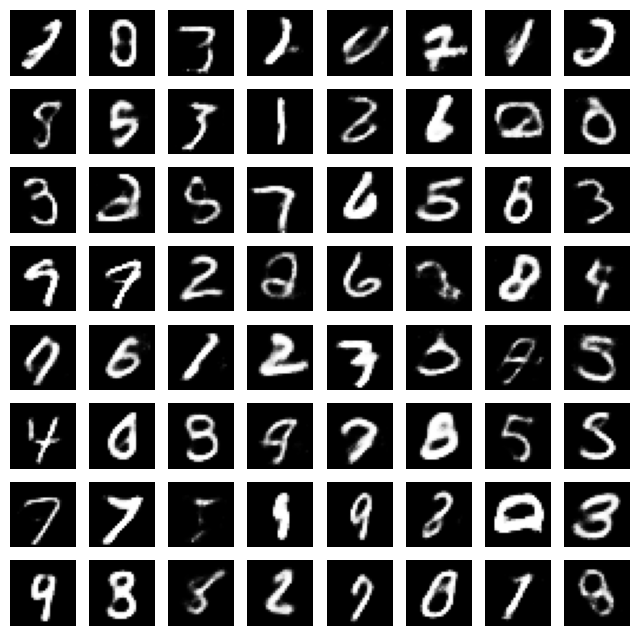

In [45]:
import matplotlib.pyplot as plt

# Generate samples
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    samples = vae.decoder(z).view(-1, 1, 28, 28).cpu()

# Plot samples
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].squeeze(0), cmap="gray")
    ax.axis("off")
plt.show()

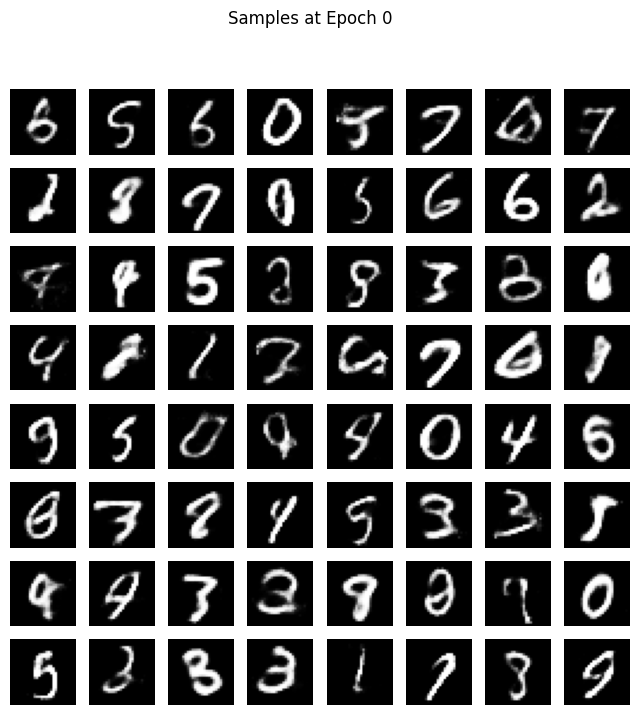

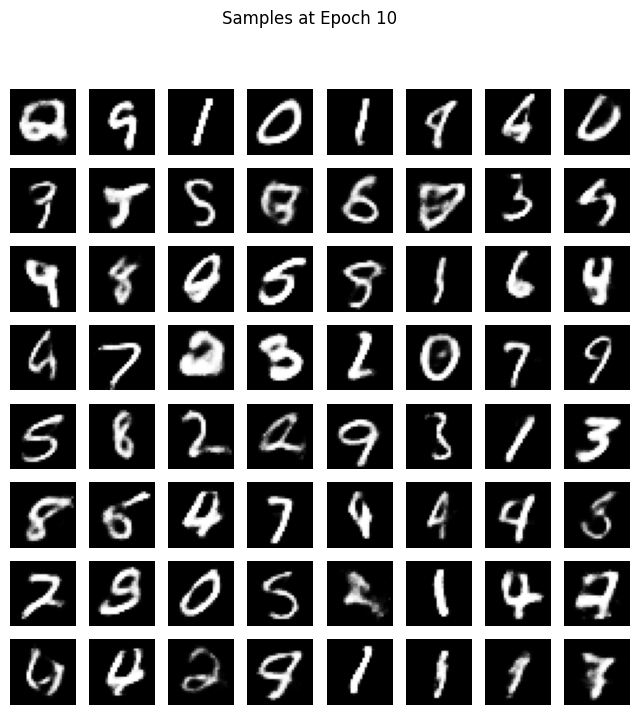

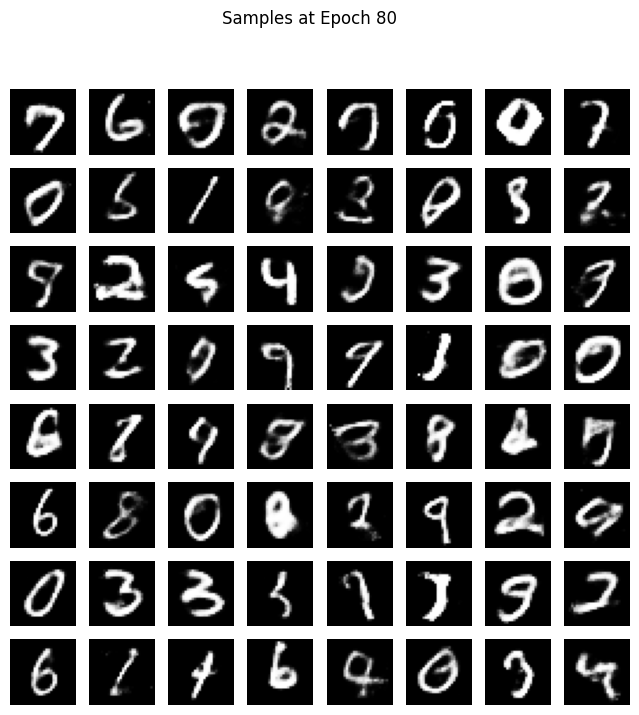

In [46]:
## question 10
import matplotlib.pyplot as plt
import torch

def plot_samples(vae, epoch, device, num_samples=64):
    """Generates and plots samples from the VAE decoder."""
    vae.eval()
    with torch.no_grad():
        # Sample latent vectors from standard normal distribution
        z = torch.randn(num_samples, vae.encoder.fc_mu.out_features).to(device)
        samples = vae.decoder(z).view(-1, 28, 28).cpu()

    # Plot the samples in an 8x8 grid
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.suptitle(f"Samples at Epoch {epoch}")
    plt.show()

# Generate samples at different stages of training
plot_samples(vae, epoch=0, device=device)   # Before training
plot_samples(vae, epoch=10, device=device)  # After 10 epochs
plot_samples(vae, epoch=80, device=device)  # After 80 epochs

#comments: we indeed see an improvement of the reconstruction 

### Part 2 : Diffusion

---
##### Question 11: new ELBO

The goal is to derive the Evidence Lower Bound (ELBO) for the Markovian Hierarchical Variational Autoencoder (MHVAE), starting from the log-likelihood of the data.

The log-likelihood is:
$$
\log p_\theta(x) = \log \int p_\theta(x, z_{1:T}) \, dz_{1:T}.
$$

Using the variational posterior $ q_\phi(z_{1:T}|x) $, we rewrite:
$$
\log p_\theta(x) = \log \int q_\phi(z_{1:T}|x) \frac{p_\theta(x, z_{1:T})}{q_\phi(z_{1:T}|x)} \, dz_{1:T}.
$$

Applying Jensen's inequality to the log function, which is strictly concave:
$$
\log p_\theta(x) \geq \mathbb{E}_{q_\phi(z_{1:T}|x)} \left[ \log \frac{p_\theta(x, z_{1:T})}{q_\phi(z_{1:T}|x)} \right].
$$

---
##### Question 12 : Description of the Diffusion Process


###### Process Architecture

1. **Forward Process**:
   - Gradually adds noise to transform $x$ into pure noise $z_T$:
     $$
     z_t = \sqrt{\alpha_t} z_{t-1} + \sqrt{1 - \alpha_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I).
     $$
   - This is a Markovian process where $z_t$ depends only on $z_{t-1}$.

2. **Reverse Process**:
   - A neural network learns to reverse the noise and reconstruct $x$:
     $$
     p_\theta(z_{t-1} | z_t) = \mathcal{N}(z_{t-1}; \mu_\theta(z_t, t), \Sigma_\theta(z_t, t)).
     $$
   - The mean $\mu_\theta$ and covariance $\Sigma_\theta$ are predicted by the model.

#### Inputs and Outputs

- **Inputs**:
  - $x$: Original data (e.g., images).
  - $t$: Time step (controls noise level at each step).
  - $\alpha_t$: Noise schedule determining the amount of noise added.

- **Outputs**:
  - **Forward Process**: Noisy versions $z_t$ at different time steps, ending with $z_T \sim \mathcal{N}(0, I)$.
  - **Reverse Process**: Reconstructed data $\hat{x}$ by iteratively denoising $z_T$.



---
##### Question 13: comments on the new ELBO terms
There are components that are similar to what we had before, plus a new consistency element:
###### 1. **Reconstruction Term**: 
$$
\mathbb{E}_{q(z_1|x)} [\log p_\theta(x|z_1)].
$$
- Same interpretation as before

###### 2. **Prior Matching Term**:
$$
- \mathbb{E}_{q(z_{T-1}|x)} [D_{\text{KL}}(q(z_T|z_{T-1}) \| p(z_T))].
$$
- This term ensures that the final variable $z_T$ is close to the prior $p(z_T)$.
- It penalizes large deviations between the learned posterior $q(z_T|z_{T-1})$ and the fixed prior $p(z_T)$.
###### 3. **Consistency Terms**:
$$
- \sum_{t=2}^T \mathbb{E}_{q(z_{t-1}, z_t|x)} [D_{\text{KL}}(q(z_t|z_{t-1}) \| p_\theta(z_t|z_{t+1}))].
$$
- This term ensures that the learned transitions $q(z_t|z_{t-1})$ are consistent with the transitions defined by the reverse model $p_\theta(z_t|z_{t+1})$

---
#### Question 14

**General Recursive Formula**

For general $t$, recursively applying the process gives:
$$
z_t = \sqrt{\bar{\alpha}_t} z_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon,
$$
where:
$$
\bar{\alpha}_t = \prod_{s=1}^t \alpha_s,
$$

Using linear combinations of gaussian variables, we obtain the result wanted.

---
##### **Question 15**

Plugging equations for $\mu_q$ and $\mu_\theta$ into the KL divergence optimization term:
$$
\text{argmin}_\theta \, D_{\text{KL}}(q(z_{t-1}|z_t, z_0) \| p_\theta(z_{t-1}|z_t)),
$$
yields:
$$
\text{argmin}_\theta \, \frac{1}{2 \sigma_q^2(t)} \| \mu_q - \mu_\theta \|_2^2,
$$
where:
$$
\mu_q = \frac{\sqrt{\alpha_t (1 - \bar{\alpha}_{t-1})} z_t + \sqrt{\bar{\alpha}_{t-1} (1 - \alpha_t)} z_0}{1 - \bar{\alpha}_t},
$$
and $\mu_\theta$ is a neural network prediction.

**Interpretation**:  
This minimizes the squared error between the predicted mean $\mu_\theta(z_t, t)$ and the true $\mu_q$, weighted by the noise variance $\sigma_q^2(t)$. The model learns to denoise effectively at each step.



---

### **Question 16**

Signal-to-noise ratio (SNR) is defined as:
$$
\text{SNR} = \frac{\mu^2}{\sigma^2}.
$$

For $q(z_t|z_0)$:
$$
z_t \sim \mathcal{N}(\sqrt{\bar{\alpha}_t} z_0, (1 - \bar{\alpha}_t) I),
$$
the SNR at timestep $t$ is:
$$
\text{SNR}_t = \frac{\bar{\alpha}_t}{1 - \bar{\alpha}_t}.
$$



---

### **Question 17**

Putting SNR into the KL divergence:
$$
\sigma_q^2(t) = \frac{(1 - \alpha_t)(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t}.
$$

The variance is proportional to 1/SNR.  
**Interpretation**: The higher the SNR, the smaller the noise variance $\sigma_q^2(t)$, making the reconstruction at timestep $t$ more confident. This links with the definition of the SNR, since the more you have signal to noise, the more you should be able to find information. Low SNR correspond to higher uncertainty.



---
## **Diffusion in practice**
### **Question 18**

In [4]:
import torch
from diffusers import DiffusionPipeline, EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler, LMSDiscreteScheduler
import matplotlib.pyplot as plt
import os

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

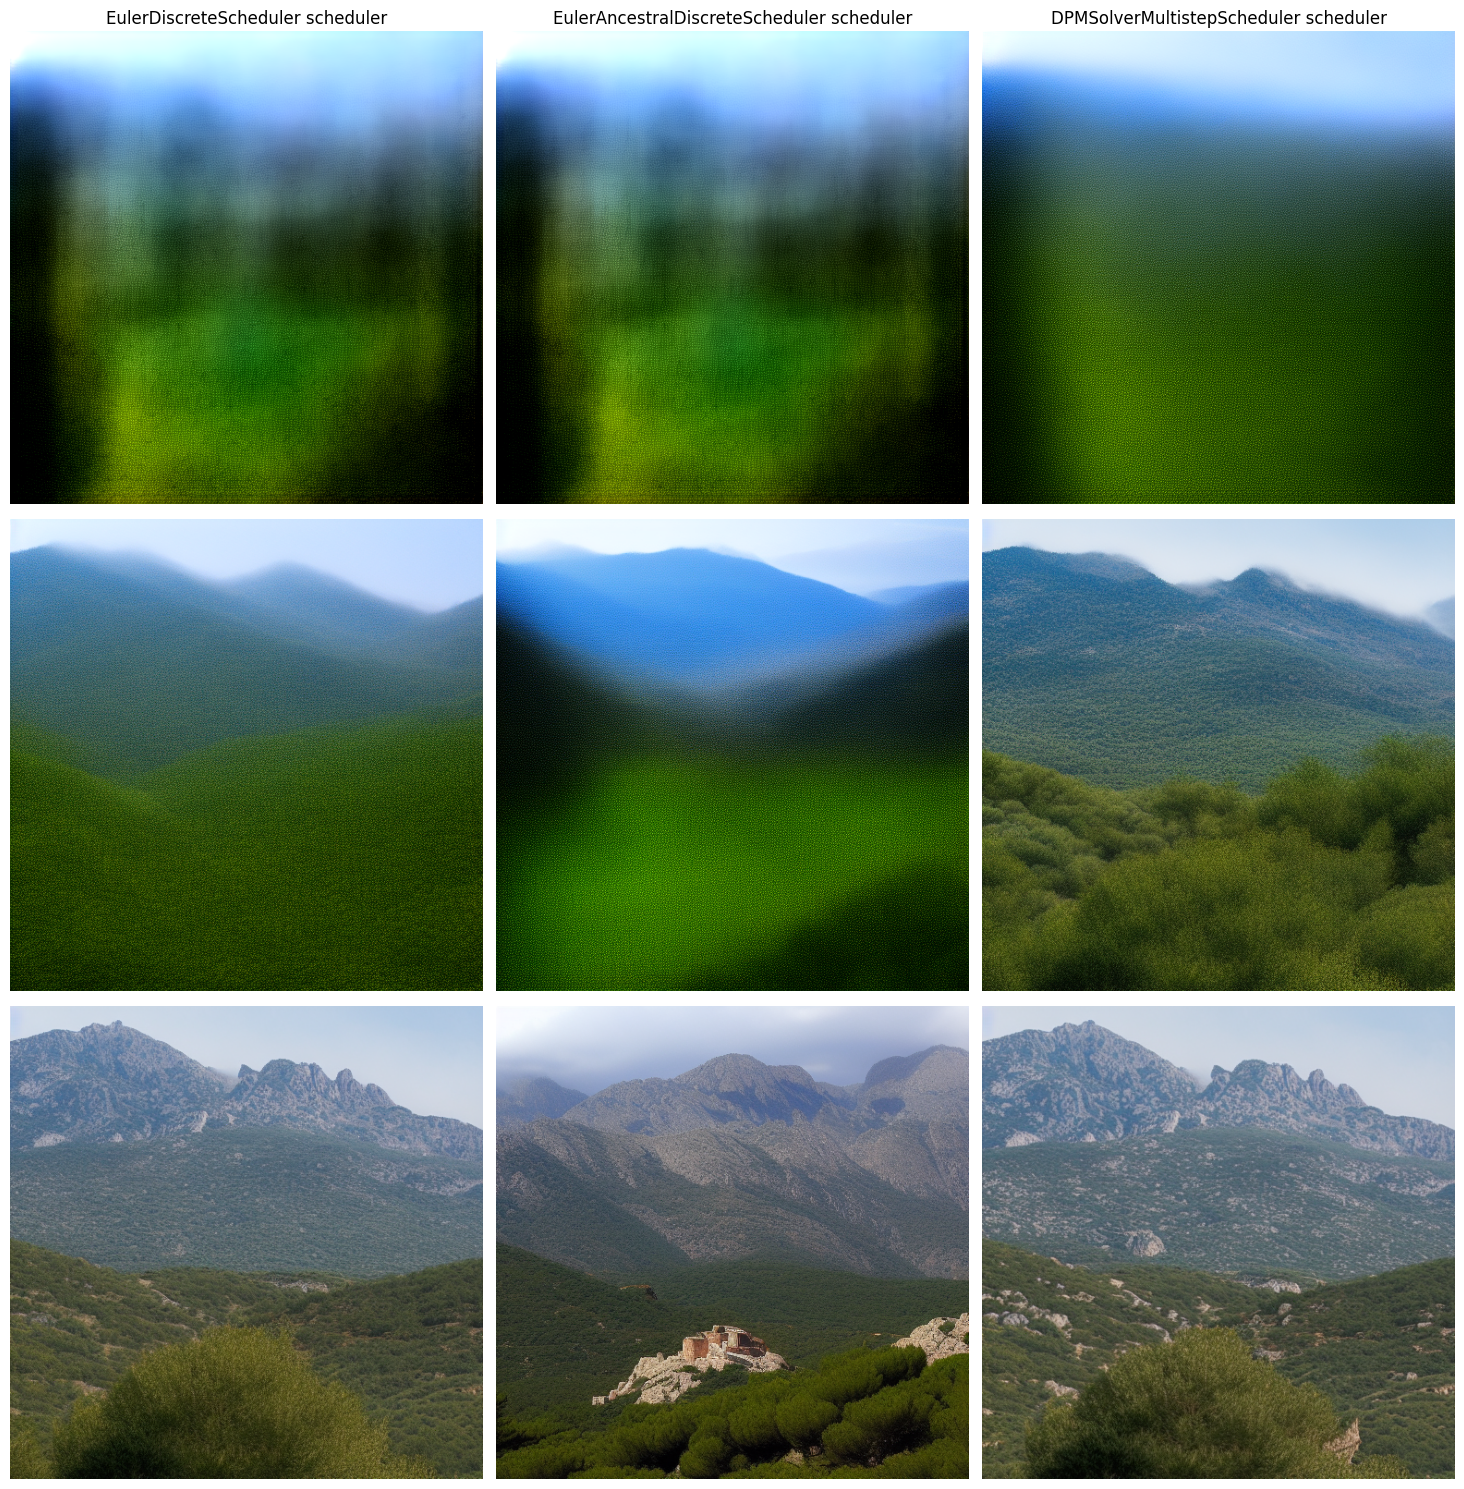

In [6]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
torch.set_num_threads(16)
seed = 42
device = 'cpu'

pipeline_1 = DiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5"
).to(device)
pipeline_1.scheduler = EulerDiscreteScheduler.from_config(pipeline_1.scheduler.config)

pipeline_2 = DiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5"
).to(device)
pipeline_2.scheduler = EulerAncestralDiscreteScheduler.from_config(pipeline_2.scheduler.config)

pipeline_3 = DiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5"
).to(device)
pipeline_3.scheduler = DPMSolverMultistepScheduler.from_config(pipeline_3.scheduler.config)

timesteps_list = [2, 5, 20]
prompt = "Mountains near Corte, Corsica"

fig, axes = plt.subplots(len(timesteps_list), 3, figsize=(15, 15))

for j, scheduler_pipeline in enumerate([pipeline_1, pipeline_2, pipeline_3]):
    for i, num_steps in enumerate(timesteps_list):
        generator = torch.Generator(device=device).manual_seed(seed)
        image = scheduler_pipeline(prompt, generator=generator, num_inference_steps=num_steps).images[0]
        axes[i, j].imshow(image)
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(f'{type(scheduler_pipeline.scheduler).__name__} scheduler')

        if j == 0:
            axes[i, j].set_ylabel(num_steps, rotation=90, size='large')

plt.subplots_adjust(left=0.07)  # Add space for y-axis labels
plt.tight_layout()
plt.show()

#### To generate just one image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

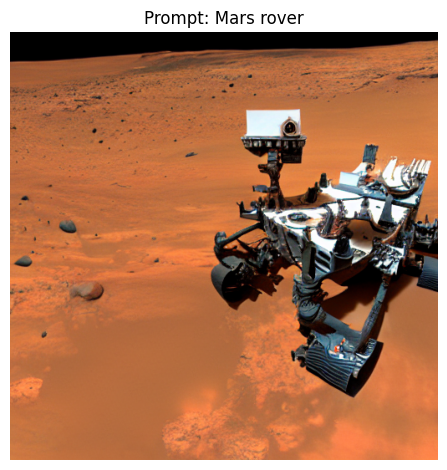

In [11]:
# Just for fun
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
torch.set_num_threads(16)
seed = 42
device = 'cpu'


pipeline = DiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5"
).to(device)
pipeline.scheduler = LMSDiscreteScheduler.from_config(pipeline.scheduler.config)

prompt = "Mars rover"
num_steps = 100
seed = 12

generator = torch.Generator(device=device).manual_seed(seed)
image = pipeline(prompt,generator=generator, num_inference_steps=num_steps).images[0]
plt.imshow(image)
plt.axis('off')
plt.title(f'Prompt: {prompt}')

plt.tight_layout()
plt.show()

---
#### Question 19

In [19]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

def MyGenerator(prompt, negative_prompt, torch_device, num_inference_steps, seed):
    
    vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
    tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(
        "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
    )
    unet = UNet2DConditionModel.from_pretrained(
        "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
    )
    
    from diffusers import UniPCMultistepScheduler
    
    scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
    
    vae.to(torch_device)
    text_encoder.to(torch_device)
    unet.to(torch_device)
    
    
    height = 512  # default height of Stable Diffusion
    width = 512  # default width of Stable Diffusion
    guidance_scale = 7.5  # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)  # Seed generator to create the initial latent noise
    batch_size = len(prompt)
    
    text_input = tokenizer(
        prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
    )
    negative_input = tokenizer(
        negative_prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
    )
    
    
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    with torch.no_grad():
        negative_embeddings = text_encoder(negative_input.input_ids.to(torch_device))[0]
    
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings, negative_embeddings])
    
    latents = torch.randn(
        (batch_size, unet.config.in_channels, height // 8, width // 8),
        generator=generator,
        device=torch_device,
    )
    latents = latents * scheduler.init_noise_sigma
    from tqdm.auto import tqdm
    
    scheduler.set_timesteps(num_inference_steps)
    
    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 3)
    
        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
    
        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
        # perform guidance
        noise_pred_uncond, noise_pred_text, noise_pred_negative = noise_pred.chunk(3)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond) - 2 * guidance_scale * (noise_pred_negative - noise_pred_uncond)
    
        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
        
    image = (image / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)
    return image

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

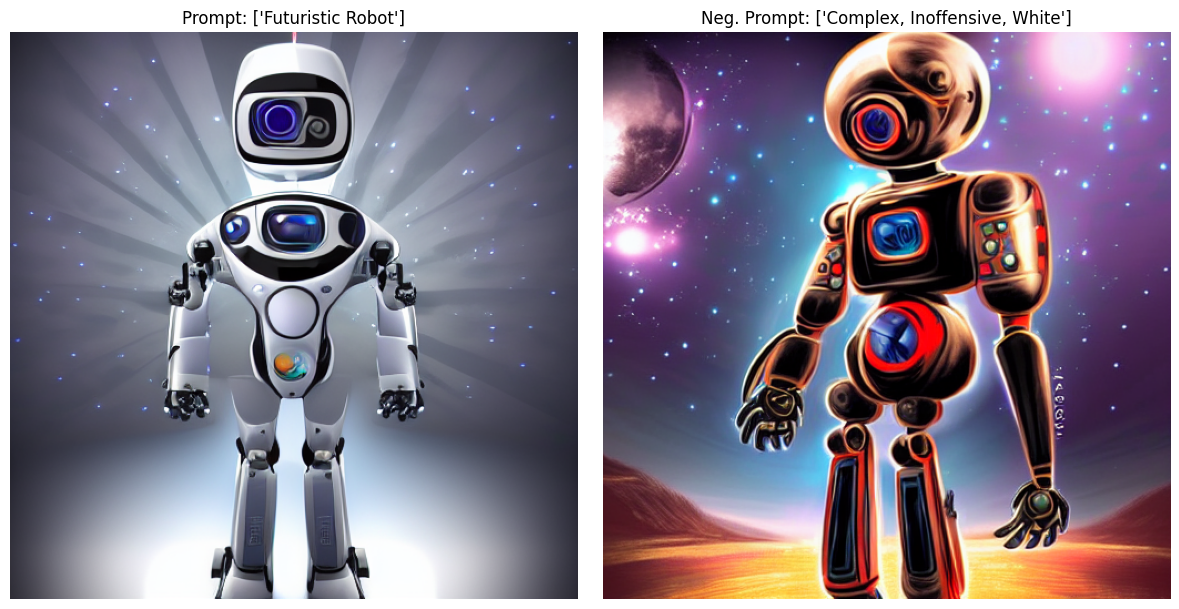

In [29]:
torch_device = "cpu"
prompt = ["Futuristic Robot"]
negative_prompt = ["Complex, Inoffensive, White"]  
num_inference_steps = 50  # Number of denoising steps
seed = 1

image_basic = MyGenerator(prompt=prompt, negative_prompt="",torch_device=torch_device,num_inference_steps=num_inference_steps,seed=seed)

image_modified = MyGenerator(prompt=prompt, negative_prompt=negative_prompt,torch_device=torch_device,num_inference_steps=num_inference_steps,seed=seed)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the basic image
axes[0].imshow(image_basic)
axes[0].set_title(f"Prompt: {prompt}")
axes[0].axis("off")  # Hide the axis

# Plot the modified image
axes[1].imshow(image_modified)
axes[1].set_title(f"Neg. Prompt: {negative_prompt}")
axes[1].axis("off")  # Hide the axis

# Show the plot
plt.tight_layout()
plt.show()

 ## B. Natural Language Processing Part
 #### 3. Multi-lingual Translation 

---
##### Question 20:
 To derive analytically the impact of that different sequence of layers, when doing back-propagation
 during training, we denote by $e$ the error produced in one pass, and $x_L$ the top-most layer. 
 
By applying chain rule:
$$
\frac{\partial e}{\partial x_\ell} = \frac{\partial e}{\partial x_L} \frac{\partial x_L}{\partial x_\ell}
$$

Then, we compute the following using eq.(31) for the Post-Layer Normalization: 
$\frac{\partial x_{l+1}}{\partial x_{l}} =\frac{\partial}{\partial x_{l}} Layernorm(x_l + \mathcal{A}(x_l))= \frac{\partial Layernorm}{\partial x}(x_l + \mathcal{A}(x_l)) \times (\frac{\partial}{\partial x_l}(x_l + \mathcal{A}(x_l))) = \frac{\partial Layernorm}{\partial x}(x_l + \mathcal{A}(x_l)) \times (Id + \frac{\partial \mathcal{A}(x_l)}{\partial x_l}) $

On the other end, we compute the following using eq.(32) for the Pre-Layer Normalization:

$\frac{\partial x_{l+1}}{\partial x_{l}} =\frac{\partial}{\partial x_{l}} (x_l + \mathcal{A}(Layernorm(x_l))) = Id + \frac{\partial Layernorm(x_l)}{\partial x_l} \times \frac{\partial \mathcal{A}}{\partial x}(Layernorm(x_l))$

Note that the notation $\frac{\partial F}{\partial x}$ denotes the Jacobian matrix of the operator $F$, in our case $Layernorm$ and $\mathcal{A}$. I leave it in a general form as requested.

---
##### Question 21: interpretation
One of the key observations we can make on the first approach (Post-Norm) is that it is sensitive to the **Vanishing Gradient** problem, since all of the backpropagation go into the softmax function, as it is also remarked in the second reference below, in appendix A.3, which find a similar result of backpropagation/derivatives to prove it.

On the other end, the Pre-LN form shows more stability and convergence in theory (as verified in practice and this is why some deep models are based on it), as the Id term prevents gradient vanishing. Moreover, the equation we found is more homogenous, because it only involves the $Layernorm(x_l)$ term and the Jacobian matrices, leading to more interpretability, which is important as these models are quite difficult to understand. Moreover, the interpretability is also important to prove a models is reliable in an industrial context. 

We should note that for shallow networks, the Post-LN shows better results (see first reference), but recent NLP models are very deep (gpt...), so we would prefer to use Pre-LN...

*NB: my answer relies on my interpretation but also uses these references: https://arxiv.org/pdf/2206.00330v1 and https://arxiv.org/pdf/2004.08249, which discuss Pre and Post LN.*


---
##### Final question 22:

Training Pre-LN model...
Epoch 1, Loss: 9.0659
Epoch 2, Loss: 3.6770
Epoch 3, Loss: 0.7003
Epoch 4, Loss: 0.1084
Epoch 5, Loss: 0.0560
Epoch 6, Loss: 0.0223
Epoch 7, Loss: 0.0273
Epoch 8, Loss: 0.0116
Epoch 9, Loss: 0.0134
Epoch 10, Loss: 0.0147
Training Post-LN model...
Epoch 1, Loss: 9.8685
Epoch 2, Loss: 9.0431
Epoch 3, Loss: 8.2885
Epoch 4, Loss: 7.4910
Epoch 5, Loss: 6.6814
Epoch 6, Loss: 5.9464
Epoch 7, Loss: 5.4267
Epoch 8, Loss: 4.9959
Epoch 9, Loss: 4.7940
Epoch 10, Loss: 4.6023


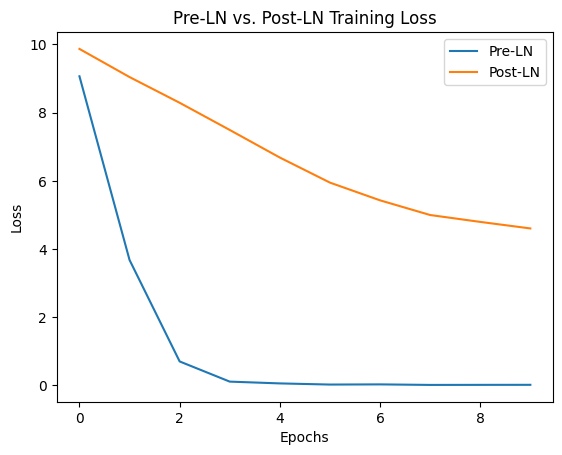

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

paragraph = [
    "The financial markets have been highly volatile due to unexpected geopolitical events.",
    "Advances in machine learning are transforming the field of natural language processing at an unprecedented pace.",
    "Astronomers have discovered a new exoplanet that might support liquid water, reigniting the search for extraterrestrial life.",
    "Climate change continues to accelerate, with record-breaking temperatures and rising sea levels being observed globally.",
    "In the world of competitive sports, mental resilience often distinguishes champions from the rest.",
    "Cryptographic protocols are essential for secure communications, especially in an era of rising cyber threats.",
    "The evolution of quantum computing could render classical encryption schemes obsolete within the next decade.",
    "Recent breakthroughs in renewable energy have significantly reduced the cost of solar and wind power production.",
    "Artificial intelligence is poised to revolutionize industries, automating routine tasks and enabling intelligent decision-making.",
    "Theoretical physics seeks to reconcile quantum mechanics with general relativity, a task that has eluded scientists for decades."
]

# Define Pre-LN Transformer block
class TransformerBlockPreLN(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward, dropout=0.1):
        super(TransformerBlockPreLN, self).__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
        )

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        # For MultiheadAttention, need shape [seq_len, batch_size, d_model]
        x = x.permute(1, 0, 2)
        attn_out = self.attention(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + attn_out
        x = x + self.feedforward(self.norm2(x))
        x = x.permute(1, 0, 2)
        return x


# Define Post-LN Transformer block
class TransformerBlockPostLN(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward, dropout=0.1):
        super(TransformerBlockPostLN, self).__init__()
        self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x.permute(1, 0, 2)
        x = x + self.attention(x, x, x)[0]
        x = self.norm1(x)
        x = x + self.feedforward(x)
        x = self.norm2(x)
        x = x.permute(1, 0, 2)
        return x


# Define a toy dataset
class ToyDataset(Dataset):
    def __init__(self, tokenizer, sequences, seq_length):
        # We'll just tokenize and get input_ids
        # Each sample: input_ids are [seq_length], we predict the next token
        tokenized = tokenizer(sequences, truncation=True, padding="max_length", max_length=seq_length, return_tensors="pt")["input_ids"]
        self.data = tokenized

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return input and target shifted by one
        x = self.data[idx][:-1]      # [seq_length-1]
        y = self.data[idx][1:]       # predict next token
        return x, y


# Define a wrapper model with embedding and output layer
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, dim_feedforward, dropout, block_type="pre"):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        if block_type == "pre":
            self.layers = nn.Sequential(*[TransformerBlockPreLN(d_model, num_heads, dim_feedforward, dropout=dropout) for _ in range(num_layers)])
        else:
            self.layers = nn.Sequential(*[TransformerBlockPostLN(d_model, num_heads, dim_feedforward, dropout=dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # x: [batch_size, seq_len]
        x = self.embedding(x)  # [batch_size, seq_len, d_model]
        x = self.layers(x)     # [batch_size, seq_len, d_model]
        x = self.output_layer(x)  # [batch_size, seq_len, vocab_size]
        return x


# Training function
def train_model(model, dataloader, optimizer, criterion, device, epochs=10):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # outputs: [batch_size, seq_len, vocab_size]
            # targets: [batch_size, seq_len]
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    return losses


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    seq_length = 16
    dataset = ToyDataset(tokenizer, paragraph * 10, seq_length=seq_length)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    d_model = 128
    num_heads = 4
    dim_feedforward = 512
    dropout = 0.1
    num_layers = 18
    vocab_size = tokenizer.vocab_size

    # Pre-LN model
    pre_ln_model = TransformerModel(vocab_size, d_model, num_layers, num_heads, dim_feedforward, dropout, block_type="pre").to(device)
    optimizer_pre = torch.optim.Adam(pre_ln_model.parameters(), lr=0.001)

    # Post-LN model
    post_ln_model = TransformerModel(vocab_size, d_model, num_layers, num_heads, dim_feedforward, dropout, block_type="post").to(device)
    optimizer_post = torch.optim.Adam(post_ln_model.parameters(), lr=0.001)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    print("Training Pre-LN model...")
    pre_ln_losses = train_model(pre_ln_model, dataloader, optimizer_pre, criterion, device, epochs=10)

    print("Training Post-LN model...")
    post_ln_losses = train_model(post_ln_model, dataloader, optimizer_post, criterion, device, epochs=10)

    # Plot results
    plt.plot(pre_ln_losses, label="Pre-LN")
    plt.plot(post_ln_losses, label="Post-LN")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Pre-LN vs. Post-LN Training Loss")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


###### **Description of the experiment, results:**
The model used in this experiment is a Transformer, where we apply Pre vs Post LN. I use an 18 layer model to reproduce one of the experiments of https://arxiv.org/pdf/2004.08249, to see that the Post LN is indeed, as they found, non-convergent and suffers from the gradient vanishing problem. Moreover, wee see the pre-LN converges and converges faster, as expected.